<a href="https://colab.research.google.com/github/Saif-rathod/rlhf_from_scratch/blob/main/RM_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reward Model Training

In [1]:
from transformers import AutoTokenizer
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
%pip install datasets==3.5.0

In [3]:
from datasets import load_dataset
dataset_name = 'sst2'
dataset = load_dataset(dataset_name)
dataset

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [4]:
ds_train, ds_val = dataset['train'], dataset['validation']

In [5]:
ds_train[4]

{'idx': 4,
 'sentence': 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ',
 'label': 0}

## Tokenize the dataset

In [6]:
REWARD_TOKEN_ID = tokenizer.eos_token_id

In [7]:
REWARD_TOKEN_ID

50256

In [8]:
def tokenize(batch):
    outputs = tokenizer(batch['sentence'])
    outputs['score'] = [0] * len(outputs['input_ids'])
    outputs['score_index'] = [0] * len(outputs['input_ids'])
    for i in range(len(outputs['input_ids'])):
        outputs['input_ids'][i].append(REWARD_TOKEN_ID)
        outputs['attention_mask'][i].append(1)
        outputs['score'][i] = float(batch['label'][i])
        outputs['score_index'][i] = len(outputs['input_ids'][i]) - 1
    return outputs

map_kwargs = {
    "batched": True,
    "batch_size": 512,
    "remove_columns": ['idx', 'sentence', 'label']
}

tokenized_dataset_train = ds_train.map(tokenize, **map_kwargs)
tokenized_dataset_val = ds_val.map(tokenize, **map_kwargs)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [9]:
tokenized_dataset_train[4]

{'input_ids': [261,
  262,
  5290,
  15827,
  12,
  1659,
  12,
  1169,
  12,
  1008,
  9310,
  35478,
  20954,
  262,
  28303,
  714,
  47478,
  469,
  510,
  220,
  50256],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'score': 0.0,
 'score_index': 20}

In [10]:
tokenized_dataset_train.set_format(type='torch')
tokenized_dataset_val.set_format(type='torch')

In [11]:
tokenized_dataset_train[4]

{'input_ids': tensor([  261,   262,  5290, 15827,    12,  1659,    12,  1169,    12,  1008,
          9310, 35478, 20954,   262, 28303,   714, 47478,   469,   510,   220,
         50256]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'score': tensor(0.),
 'score_index': tensor(20)}

### Filter out shorter tweets

In [12]:
tokenized_dataset_train = tokenized_dataset_train.filter(lambda x: len(x['input_ids']) > 6)
tokenized_dataset_val = tokenized_dataset_val.filter(lambda x: len(x['input_ids']) > 6)

Filter:   0%|          | 0/67349 [00:00<?, ? examples/s]

Filter:   0%|          | 0/872 [00:00<?, ? examples/s]

In [13]:
len(tokenized_dataset_train)

49401

## LLM with Reward Head

In [14]:
import torch
from torch import nn
import numpy as np
from transformers import AutoModelForCausalLM

class RewardHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.reward = nn.Linear(self.hidden_size, 1)
        self._post_init()

    def _post_init(self):
        nn.init.normal_(self.reward.weight, std=(1.0 / np.sqrt(self.hidden_size + 1)))
        nn.init.zeros_(self.reward.bias)

    def forward(self, hidden_states):
        return self.reward(hidden_states)

class GPT2RewardHead(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.llm = AutoModelForCausalLM.from_pretrained(model_name)
        self.reward_head = RewardHead(self.llm.config)

    def forward(self, input_ids, attention_mask):
        transformer_outputs = self.llm.forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        last_hidden_state = transformer_outputs.hidden_states[-1]
        reward = self.reward_head(last_hidden_state).squeeze(-1)
        return torch.sigmoid(reward)


In [15]:
model = GPT2RewardHead(model_name)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [16]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

tokenizer.pad_token = tokenizer.eos_token

data_collator = DataCollatorWithPadding(tokenizer)
dataloader_params = {
    'batch_size': 64,
    'shuffle': True,
    'collate_fn': data_collator
}
train_dataloader = DataLoader(tokenized_dataset_train, **dataloader_params)
val_dataloader = DataLoader(tokenized_dataset_val, **dataloader_params)

In [17]:
batch = next(iter(train_dataloader))
print(batch.keys())

KeysView({'input_ids': tensor([[19692, 21372,  5300,  ..., 50256, 50256, 50256],
        [   82,   324,   306,  ..., 50256, 50256, 50256],
        [ 1659,  1165,   881,  ..., 50256, 50256, 50256],
        ...,
        [14150,  1813, 15579,  ..., 50256, 50256, 50256],
        [  372,  1940,    82,  ..., 50256, 50256, 50256],
        [ 3866,  1151,   663,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'score': tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 0.]), 'score_index': tensor([37, 18,  7,  8,  8, 19, 38, 10,  6,  8, 11,  8, 23, 22,

In [18]:
print(batch['input_ids'][1])
print(batch['attention_mask'][1])
print(batch['score'][1])
print(batch['score_index'][1])

tensor([   82,   324,   306, 17742,  1752,   757, 19225,   857,   299,   470,
         1464,   467,  1021,   287,  1021,   351,  7401,   220, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.)
tensor(18)


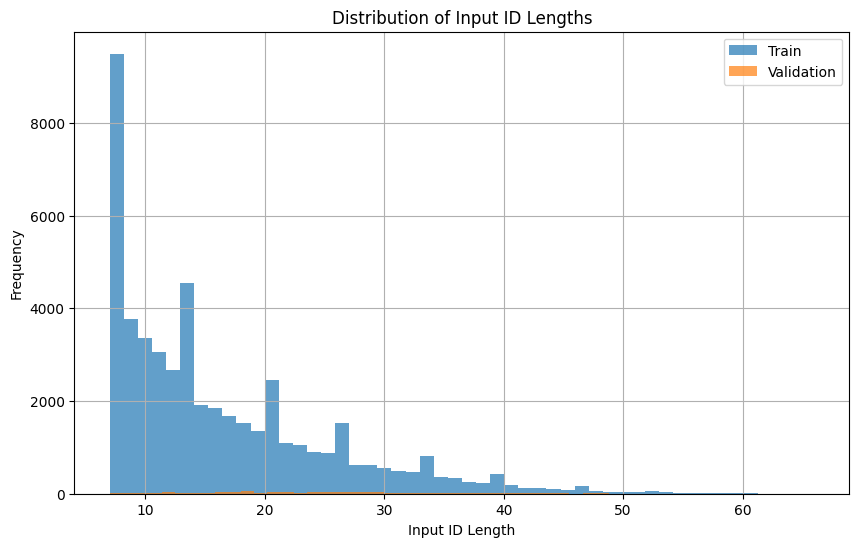

In [32]:
train_lengths = [len(x['input_ids']) for x in tokenized_dataset_train]
val_lengths = [len(x['input_ids']) for x in tokenized_dataset_val]

plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(val_lengths, bins=50, alpha=0.7, label='Validation')
plt.xlabel('Input ID Length')
plt.ylabel('Frequency')
plt.title('Distribution of Input ID Lengths')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(tokenizer.decode(batch['input_ids'][1]))

sadly proving once again ego does n't always go hand in hand with talent <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [20]:
batch['attention_mask'][1].nonzero()[-1]

tensor([18])

In [21]:
outputs = model(batch['input_ids'], batch['attention_mask'])

In [22]:
print(outputs.shape)

torch.Size([64, 48])


### Training Config

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
num_epochs = 1 # N+ Implementation Detail paper


In [34]:
from sklearn.metrics import confusion_matrix
model.eval()

all_predictions = []
all_labels = []

def validate():
    model.eval()
    total_loss = 0
    for i, batch in enumerate(val_dataloader):
        inputs = batch.to(device)
        model_inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        }
        with torch.no_grad():
            scores = model(**model_inputs)
            batch_indices = torch.arange(scores.shape[0])
            score = scores[batch_indices, inputs['score_index']]
            target = inputs['score']
            loss = criterion(score, target)
        total_loss += loss.item()
    avg_loss = total_loss / len(val_dataloader)
    print('validation loss:', avg_loss)
    return avg_loss

### Training Loop

In [35]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
model.to(device)

avg_val_loss = validate()
val_losses.append(avg_val_loss)

for epoch in range(num_epochs):
    model.train()
    for i, batch in enumerate(train_dataloader):
        inputs = batch.to(device)
        model_inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        }
        scores = model(**model_inputs)
        batch_indices = torch.arange(scores.shape[0])
        score = scores[batch_indices, inputs['score_index']]
        target = inputs['score']
        loss = criterion(score, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())
        train_losses.append(loss.item())
    avg_val_loss = validate()
    val_losses.append(avg_val_loss)

validation loss: 0.2737962550350598
0.04893985390663147
0.044488415122032166
0.14872309565544128
0.10560248047113419
0.0917665958404541
0.08257939666509628
0.05228354036808014
0.08035941421985626
0.03904791176319122
0.03567643091082573
0.04691470414400101
0.025325454771518707
0.06147131696343422
0.08230551332235336
0.03383415937423706
0.12280980497598648
0.07798376679420471
0.05760134384036064
0.09699997305870056
0.1083274781703949
0.043463222682476044
0.01756894588470459
0.06359773874282837
0.026209615170955658
0.1150212213397026
0.019810795783996582
0.016581928357481956
0.07984289526939392
0.08327291905879974
0.08273668587207794
0.04147009551525116
0.08920381963253021
0.03035697154700756
0.042215168476104736
0.02421223372220993
0.17924875020980835
0.021433623507618904
0.03668910264968872
0.030383547767996788
0.020544961094856262
0.017225876450538635
0.0734308585524559
0.12005424499511719
0.06344680488109589
0.1011415496468544
0.04785840958356857
0.013702708296477795
0.183127060532569

Text(0.5, 1.0, 'Reward Model Loss')

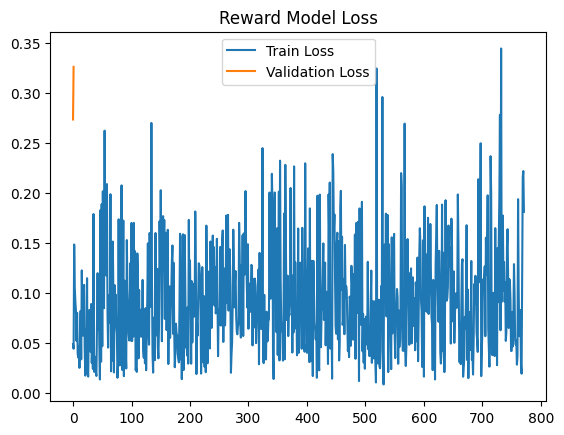

In [36]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Reward Model Loss")


In [40]:

print("Best Train Loss:", min(train_losses))
print("Best Validation Loss:", min(val_losses))

Best Train Loss: 0.008702678605914116
Best Validation Loss: 0.2737962550350598


In [41]:
torch.save(model.state_dict(), 'reward_model.pt')

In [43]:
val_losses

[0.2737962550350598, 0.3264482223561832]

### Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix
model.eval()

all_predictions = []
all_labels = []

for i, batch in enumerate(val_dataloader):
    inputs = batch.to(device)
    model_inputs = {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }
    with torch.no_grad():
        scores = model(**model_inputs)
        batch_indices = torch.arange(scores.shape[0])
        score = scores[batch_indices, inputs['score_index']]
        target = inputs['score']
    predictions = (score > 0.5).int()

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(target.cpu().numpy())

confusion_matrix(all_labels, all_predictions)

array([[376,  48],
       [ 38, 405]])

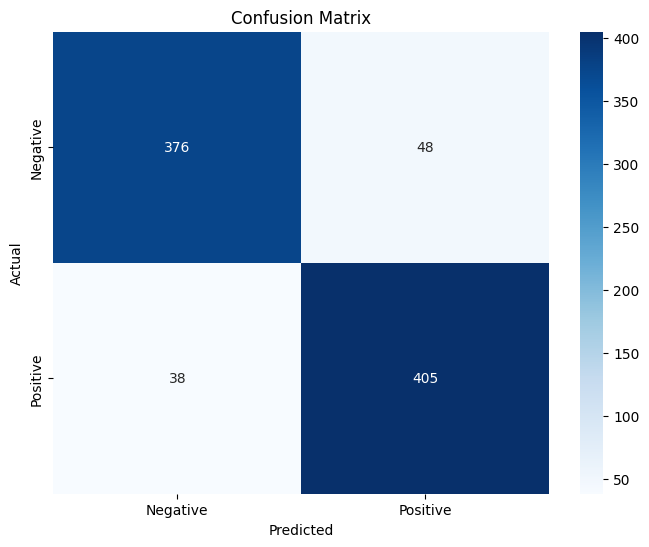

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
